<a href="https://colab.research.google.com/github/moumahan1990/retail_timeseries_forecasting/blob/master/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 83.1MB 69kB/s 
     |████████████████████████████████| 3.1MB 47.1MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


In [0]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,RNN, SimpleRNN 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
# additional store data
store = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/store.csv",low_memory = False)

In [0]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [0]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# Creating new features from date 
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [5]:
# Filtering out stores which are closed and has zero sales
train_data = train[train.Store == 1]
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]
train_data=train_data.sort_index()
train_data=train_data.fillna(0)
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
# train_data_X = train_data[['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'SalePerCustomer']]
train_data_X = train_data[['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]

In [0]:
train_data_y = train_data[['Sales']]

In [8]:
#Creating train test split
# X_train = train_data_X.head(730)
# X_test = train_data_X.tail(50)
# y_train = train_data_y.head(730)
# y_test = train_data_y.tail(50)

number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(train_data) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(train_data), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 781 681 50 50


In [9]:
datatrain = train_data[:number_of_training_data]
datatest = train_data[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = train_data[-number_of_holdout_data:]
datatrain.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
#Preparing Train,Test,Validation data for TimeSeriesGenerator
in_seq1 = array(datatrain['Month'])
in_seq2 = array(datatrain['Day'])
in_seq3 = array(datatrain['WeekOfYear'])
in_seq4 = array(datatrain['DayOfWeek'])
in_seq5 = array(datatrain['Open'])
in_seq6 = array(datatrain['Promo'])
in_seq7 = array(datatrain['StateHoliday'])
in_seq8 = array(datatrain['SchoolHoliday'])
# in_seq9 = array(datatrain['SalePerCustomer'])

out_seq_train = array(datatrain['Sales'])

In [0]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
# in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))


In [12]:
# datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_train))
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, out_seq_train))
datatrain_feed

array([[1, 2, 1, ..., '0', 1, 5530],
       [1, 3, 1, ..., '0', 1, 4327],
       [1, 4, 1, ..., '0', 1, 4486],
       ...,
       [3, 27, 13, ..., '0', 0, 4005],
       [3, 28, 13, ..., '0', 0, 5208],
       [3, 30, 14, ..., '0', 1, 6714]], dtype=object)

In [0]:
in_seq1 = array(datahold['Month'])
in_seq2 = array(datahold['Day'])
in_seq3 = array(datahold['WeekOfYear'])
in_seq4 = array(datahold['DayOfWeek'])
in_seq5 = array(datahold['Open'])
in_seq6 = array(datahold['Promo'])
in_seq7 = array(datahold['StateHoliday'])
in_seq8 = array(datahold['SchoolHoliday'])
# in_seq9 = array(datahold['SalePerCustomer'])

out_seq_hold = array(datahold['Sales'])

In [14]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
# in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))
out_seq_hold.shape

(50, 1)

In [0]:
# datathold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_hold))
datathold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, out_seq_hold))
datathold_feed

In [0]:
in_seq1 = array(datatest['Month'])
in_seq2 = array(datatest['Day'])
in_seq3 = array(datatest['WeekOfYear'])
in_seq4 = array(datatest['DayOfWeek'])
in_seq5 = array(datatest['Open'])
in_seq6 = array(datatest['Promo'])
in_seq7 = array(datatest['StateHoliday'])
in_seq8 = array(datatest['SchoolHoliday'])
# in_seq9 = array(datatest['SalePerCustomer'])

out_seq_test = array(datatest['Sales'])

In [17]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
# in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_test = out_seq_hold.reshape((len(out_seq_test), 1))
out_seq_test.shape

(50, 1)

In [18]:
# datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_test))
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, out_seq_test))
datatest_feed.shape

(50, 9)

In [0]:
# TimeSeries Generator for Train data 
n_features = datatrain_feed.shape[1]
n_input = 30
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=1)


In [0]:
for i in range(len(generator_train)):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

In [0]:
# TimeSeries Generator for Val data
generator_hold = TimeseriesGenerator(datathold_feed, out_seq_hold, length=n_input, batch_size=1)

In [0]:
for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    print('%s => %s' % (x, y))

In [0]:
# TimeSeries Generator for Test data
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [0]:
for i in range(len(generator_test)):
    x, y = generator_test[i]
    print('%s => %s' % (x, y))

In [24]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 30 9


In [38]:
#RNN  Model
model = Sequential()

model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

from tensorflow.keras.losses import MAPE
rmsprop = RMSprop(lr=0.0001)
model.compile(optimizer=rmsprop, loss=MAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 10)                200       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [39]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='max', min_delta=3,verbose=1)

# score = model.fit_generator(generator_train, epochs=100, verbose=2, validation_data=generator_test, callbacks=[es])
score = model.fit_generator(generator_train, epochs=50, verbose=2, validation_data=generator_test)

Epoch 1/50
 - 3s - loss: 106.9047 - val_loss: 101.9266
Epoch 2/50
 - 2s - loss: 100.8614 - val_loss: 100.1196
Epoch 3/50
 - 2s - loss: 99.5804 - val_loss: 98.5121
Epoch 4/50
 - 2s - loss: 95.9947 - val_loss: 92.9426
Epoch 5/50
 - 2s - loss: 86.4538 - val_loss: 78.5567
Epoch 6/50
 - 2s - loss: 55.1708 - val_loss: 17.0805
Epoch 7/50
 - 2s - loss: 15.2248 - val_loss: 11.8918
Epoch 8/50
 - 2s - loss: 14.8175 - val_loss: 11.9205
Epoch 9/50
 - 2s - loss: 14.6375 - val_loss: 11.4272
Epoch 10/50
 - 2s - loss: 14.5238 - val_loss: 11.3817
Epoch 11/50
 - 2s - loss: 14.3687 - val_loss: 11.2153
Epoch 12/50
 - 2s - loss: 14.2543 - val_loss: 11.1062
Epoch 13/50
 - 2s - loss: 14.0960 - val_loss: 10.8525
Epoch 14/50
 - 2s - loss: 13.8631 - val_loss: 10.9363
Epoch 15/50
 - 2s - loss: 13.9141 - val_loss: 10.8715
Epoch 16/50
 - 2s - loss: 13.7230 - val_loss: 10.5127
Epoch 17/50
 - 2s - loss: 13.6835 - val_loss: 10.8636
Epoch 18/50
 - 2s - loss: 13.4957 - val_loss: 10.2927
Epoch 19/50
 - 2s - loss: 13.3491

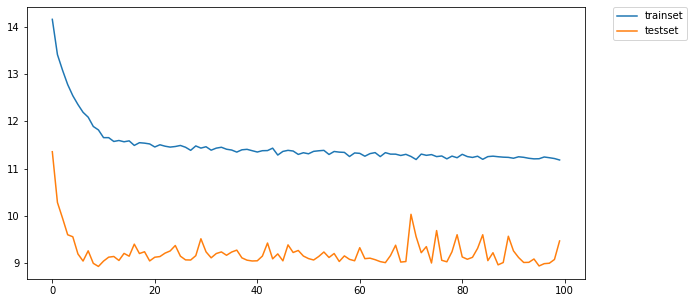

In [27]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [0]:
yhat = model.predict(generator_hold, verbose=2)

In [0]:
yhat.shape

(49, 1)

In [0]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': y[0][0], 'Prediction': yhat[0][0]}, ignore_index=True)

In [43]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_rf = sqrt(mean_squared_error(df_result.Actual, df_result.Prediction))
MAPE= np.mean(np.abs((df_result.Actual - df_result.Prediction) / df_result.Actual)) * 100
def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d
def smape(actual, predicted):
    # return 100/len(test) * np.sum(2 * np.abs(pred - test) / (np.abs(test) + np.abs(pred)))
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))
print("MAPE: ",MAPE)
print("MAE: ", mean_absolute_error(df_result.Actual, df_result.Prediction))
print("RMSE: ",rmse_rf)
print("MASE",MASE(datatrain.Sales,df_result.Actual,df_result.Prediction))
print("SMAPE",smape(df_result.Actual,df_result.Prediction))

MAPE:  8.85807525573262
MAE:  422.1322875976563
RMSE:  636.9034002996185
MASE 0.7241604368586652
SMAPE 0.09428633132915828
